In [14]:
import sys
import os

# Adiciona o diretório correto ao path
# Ajuste o caminho conforme sua estrutura real
sys.path.insert(0, os.getcwd())

from fuzzy_systems.learning.anfis import ANFIS


import numpy as np
import matplotlib.pyplot as plt

# Configurar matplotlib
%matplotlib inline
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 11
plt.rcParams['figure.dpi'] = 100

print("✅ Bibliotecas importadas com sucesso!")
print(f"   Versão do NumPy: {np.__version__}")


from sklearn.preprocessing import StandardScaler
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import pandas as pd


✅ Bibliotecas importadas com sucesso!
   Versão do NumPy: 2.3.2


In [16]:
# Load dataset
iris = load_iris()
X_full = iris.data
y_full = iris.target

# Create DataFrame
df = pd.DataFrame(X_full, columns=iris.feature_names)
df['species'] = iris.target_names[y_full]

print('📊 Iris dataset loaded!')
print(f'\nShape: {X_full.shape}')
print(f'\nClasses: {iris.target_names}')
print(f'\nFeatures: {iris.feature_names}')
df.head()

📊 Iris dataset loaded!

Shape: (150, 4)

Classes: ['setosa' 'versicolor' 'virginica']

Features: ['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)']


,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),species
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa


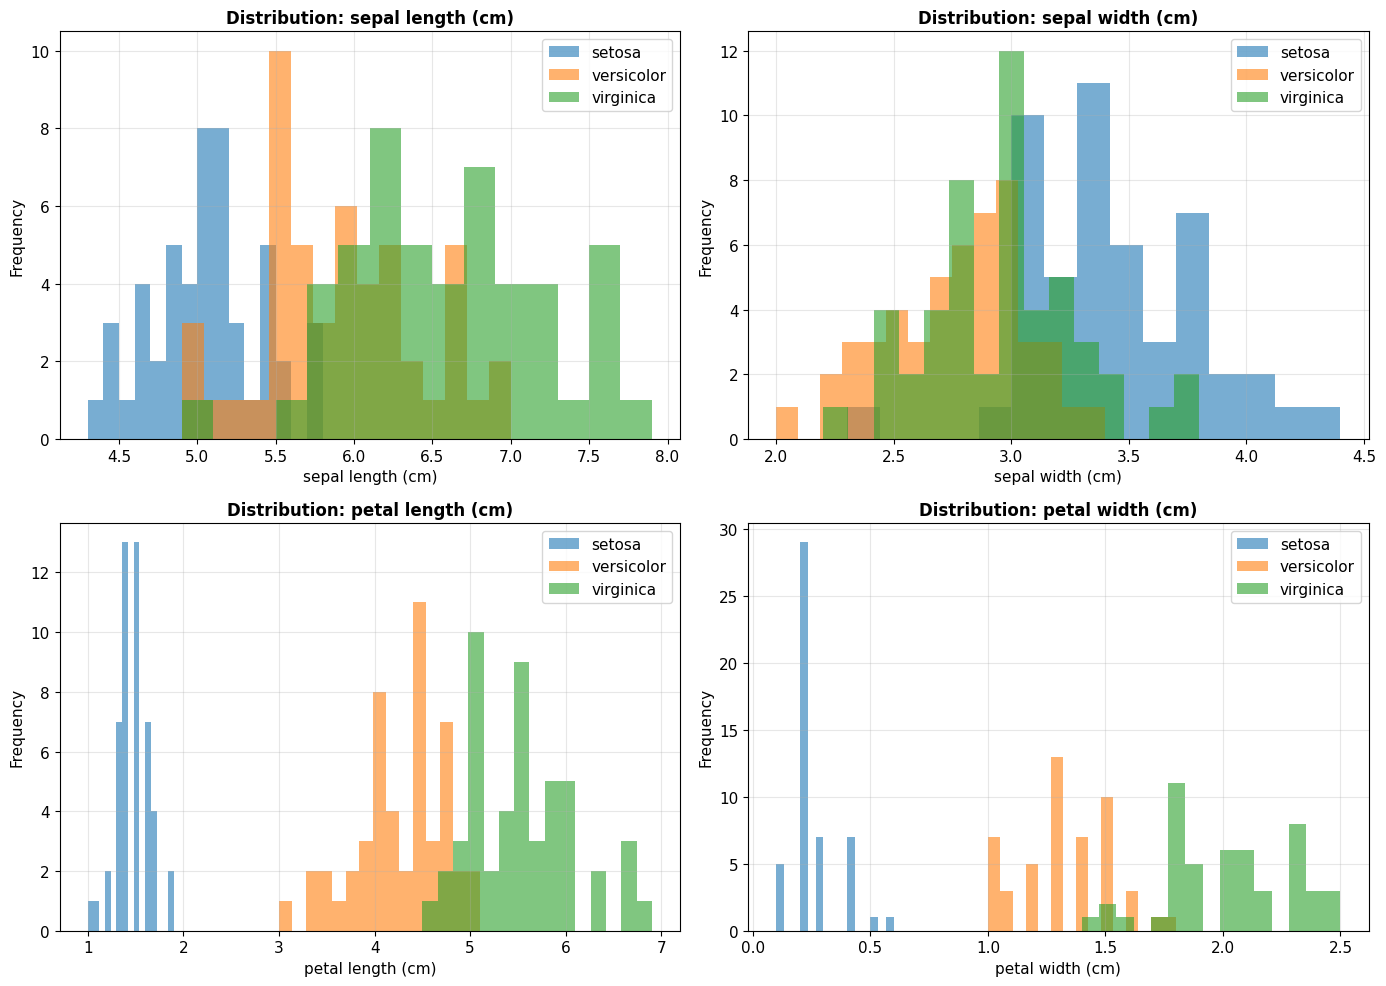

In [17]:
# Visualize feature distribution
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

for idx, feature in enumerate(iris.feature_names):
    for species_id, species_name in enumerate(iris.target_names):
        data = df[df['species'] == species_name][feature]
        axes[idx].hist(data, alpha=0.6, bins=15, label=species_name)
    
    axes[idx].set_xlabel(feature, fontsize=11)
    axes[idx].set_ylabel('Frequency', fontsize=11)
    axes[idx].set_title(f'Distribution: {feature}', fontsize=12, weight='bold')
    axes[idx].legend()
    axes[idx].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


In [6]:
# Generate synthetic data
np.random.seed(42)
n_samples = 300

# Example 1: Regression
print("="*70)
print("EXAMPLE 1: REGRESSION")
print("="*70)
X_train = np.random.uniform(-3, 3, (n_samples, 2))
y_train = (np.sin(X_train[:, 0]) +
            np.cos(X_train[:, 1]) +
            0.5 * X_train[:, 0] * X_train[:, 1] +
            np.random.normal(0, 0.1, n_samples))

# Split into train and validation
split_idx = int(0.8 * n_samples)
X_tr, X_val = X_train[:split_idx], X_train[split_idx:]
y_tr, y_val = y_train[:split_idx], y_train[split_idx:]

# Create and train model for regression
model_reg = ANFIS(n_inputs=2, n_mfs=[3, 3], mf_type='gaussmf',
                    classification=False, 
                    learning_rate=0.001,
                    lambda_l2=0.01, 
                    batch_size=128,
                    use_adaptive_lr=True)
model_reg.fit(X_tr, y_tr, epochs=200, verbose=True,
                X_val=X_val, y_val=y_val, early_stopping_patience=100)
# model_reg.summary()

# Evaluate
y_pred = model_reg.predict(X_val)
mse = np.mean((y_val - y_pred) ** 2)
r2 = model_reg.score(X_val, y_val)

print(f"\n{'=' * 70}")
print(f"Regression Results (Validation):")
print(f"  • MSE: {mse:.6f}")
print(f"  • RMSE: {np.sqrt(mse):.6f}")
print(f"  • R²: {r2:.6f}")
print(f"{'=' * 70}\n")

# Visualize
# model_reg.visualize_mfs()
# model_reg.plot_convergence()
# model_reg.plot_regularization()



EXAMPLE 1: REGRESSION

ANFIS - Treinamento
Arquitetura:
  • Entradas: 2
  • MFs por entrada: [3, 3]
  • Regras: 9
  • Tipo MF: gaussmf

Treinamento:
  • Modo: Minibatch GD
  • Samples: 240
  • Batch size: 128
  • Batches/época: 2

Regularização:
  • Tipo: Ridge (L2)
  • λ₁ (L1): 0.0
  • λ₂ (L2): 0.01

Inicializando consequentes com LSE...
RMSE inicial: 0.124224

Época   1/200 - Train RMSE: 0.135274, Val RMSE: 0.155447 | Custo: 0.076461
Época  10/200 - Train RMSE: 0.130356, Val RMSE: 0.140979 | Custo: 0.075111
Época  20/200 - Train RMSE: 0.136164, Val RMSE: 0.147133 | Custo: 0.076611
Época  30/200 - Train RMSE: 0.138780, Val RMSE: 0.145199 | Custo: 0.077281
Época  40/200 - Train RMSE: 0.134566, Val RMSE: 0.148178 | Custo: 0.076081
Época  50/200 - Train RMSE: 0.139201, Val RMSE: 0.154632 | Custo: 0.077302
Época  60/200 - Train RMSE: 0.139863, Val RMSE: 0.166108 | Custo: 0.077439
Época  70/200 - Train RMSE: 0.141515, Val RMSE: 0.153349 | Custo: 0.077856
Época  80/200 - Train RMSE: 0.14087

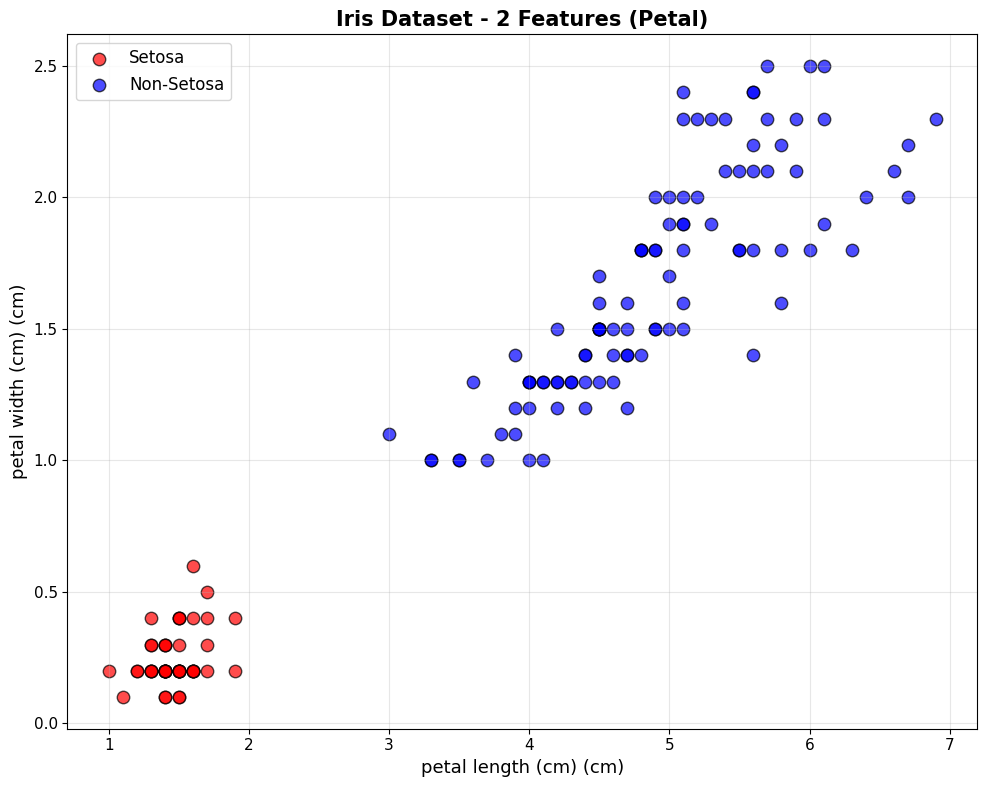

Note: Setosa is clearly separable from other classes!


In [19]:
iris = load_iris()

X = iris.data # Shape (150, 4) - 4 features
y = iris.target
y_binary = (y != 0).astype(int)  # 0 = Setosa, 1 = Não-Setosa


feature_names = iris.feature_names 
class_names = iris.target_names



# X = X[:,2:4]
# feature_names = ['Petal Length (cm)', 'Petal Width (cm)']
# class_names = ['setosa', 'versicolor', 'virginica']


#Visualize separability
fig, ax = plt.subplots(figsize=(10, 8))

colors = ['red', 'blue']
labels = ['Setosa', 'Non-Setosa']

for class_id in [0, 1]:
    mask = y_binary == class_id
    ax.scatter(X[mask, -2], X[mask, -1], 
              c=colors[class_id], label=labels[class_id],
              s=80, alpha=0.7, edgecolors='black', linewidth=1)

ax.set_xlabel(iris.feature_names[2] + ' (cm)', fontsize=13)
ax.set_ylabel(iris.feature_names[3] + ' (cm)', fontsize=13)
ax.set_title('Iris Dataset - 2 Features (Petal)', fontsize=15, weight='bold')
ax.legend(fontsize=12)
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print('Note: Setosa is clearly separable from other classes!')

In [8]:
# Example 2: Classification
print("\n" + "="*70)
print("EXAMPLE 2: CLASSIFICATION")
print("="*70)


X_train, X_temp, y_train, y_temp = train_test_split(
    X, y_binary, test_size=0.3, random_state=42, stratify=y_binary
)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

# Normalize data
scaler = StandardScaler()
X_train_norm = scaler.fit_transform(X_train)
X_val_norm = scaler.transform(X_val)
X_test_norm = scaler.transform(X_test)




print('\n✅ Dados normalizados!')
print(f'\nRanges após normalização:')
print(f'  Feature 1: [{X_train_norm[:, 0].min():.2f}, {X_train_norm[:, 0].max():.2f}]')
print(f'  Feature 2: [{X_train_norm[:, 1].min():.2f}, {X_train_norm[:, 1].max():.2f}]')



EXAMPLE 2: CLASSIFICATION

✅ Dados normalizados!

Ranges após normalização:
  Feature 1: [-1.83, 2.45]
  Feature 2: [-2.30, 2.97]


In [10]:
# Create and train model for classification
num_inputs = len(X_train_norm[0,:])
input_range = [[X_train_norm[:, idx].min(), X_train_norm[:, idx].max()] for idx in range(num_inputs)]
model_cls = ANFIS(n_inputs=num_inputs, n_mfs=[3]*num_inputs, mf_type='gaussmf',input_ranges=input_range,
                    classification=True, 
                    learning_rate=1e-1,
                    lambda_l2=0.001, batch_size=128,use_adaptive_lr=True)

model_cls.fit(X_train_norm, y_train, epochs=500, verbose=True,
                X_val=X_val_norm, y_val=y_val, early_stopping_patience=20)

# model_cls.summary()
# Evaluate
y_pred_cls = model_cls.predict(X_test_norm)
# y_proba_cls = model_cls.predict_proba(X_test_norm)
# accuracy = model_cls.score(X_test_norm, y_test)

# print(f"\n{'=' * 70}")
# print(f"Classification Results (Validation):")
# print(f"  • Accuracy: {accuracy:.4f}")
# print(f"  • Predicted classes shape: {y_pred_cls.shape}")
# print(f"  • Probabilities shape: {y_proba_cls.shape}")
# print(f"  • Sample predictions: {y_pred_cls[:5]}")
# print(f"  • Sample probabilities:\n{y_proba_cls[:5]}")
# print(f"{'=' * 70}\n")

# Visualize
# model_cls.visualize_mfs()
# model_cls.plot_convergence()

plt.show()


ANFIS - Treinamento
Arquitetura:
  • Entradas: 4
  • MFs por entrada: [3, 3, 3, 3]
  • Regras: 81
  • Tipo MF: gaussmf

Treinamento:
  • Modo: Batch GD
  • Samples: 105
  • Batch size: 105
  • Batches/época: 1

Regularização:
  • Tipo: Ridge (L2)
  • λ₁ (L1): 0.0
  • λ₂ (L2): 0.001

Inicializando consequentes com LSE...
RMSE inicial: 0.000060

Época   1/500 - Train RMSE: 0.003780, Val RMSE: 0.020359 | Custo: 0.005615
Época  10/500 - Train RMSE: 0.000063, Val RMSE: 0.017249 | Custo: 0.005581
Época  20/500 - Train RMSE: 0.000062, Val RMSE: 0.017253 | Custo: 0.005559

Early stopping na época 27
Melhor RMSE validação: 0.017249

Treinamento concluído!



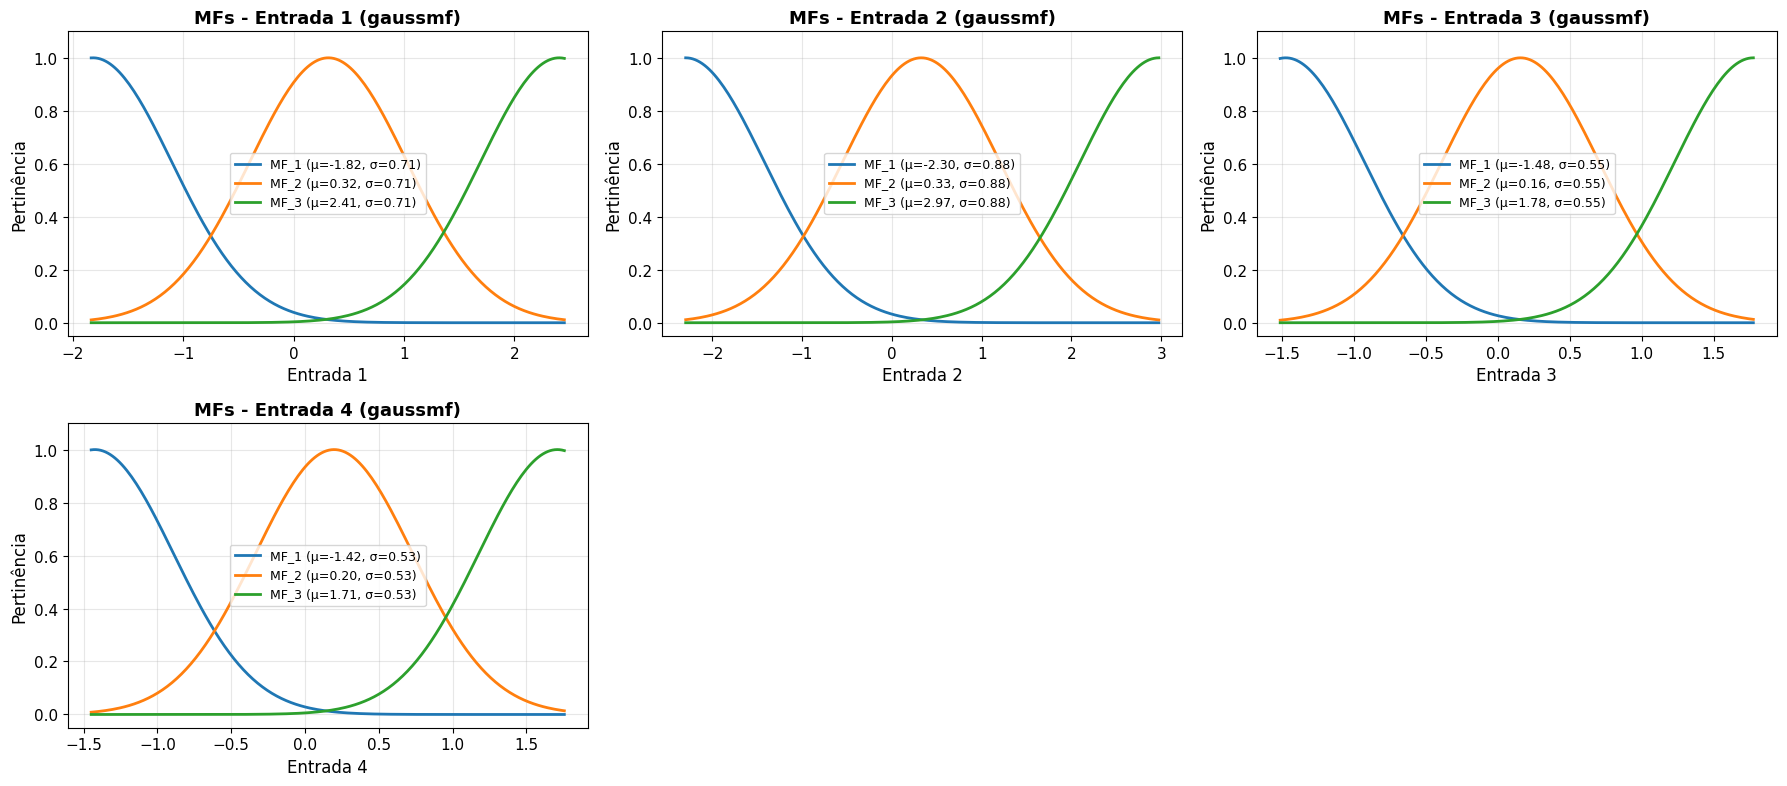

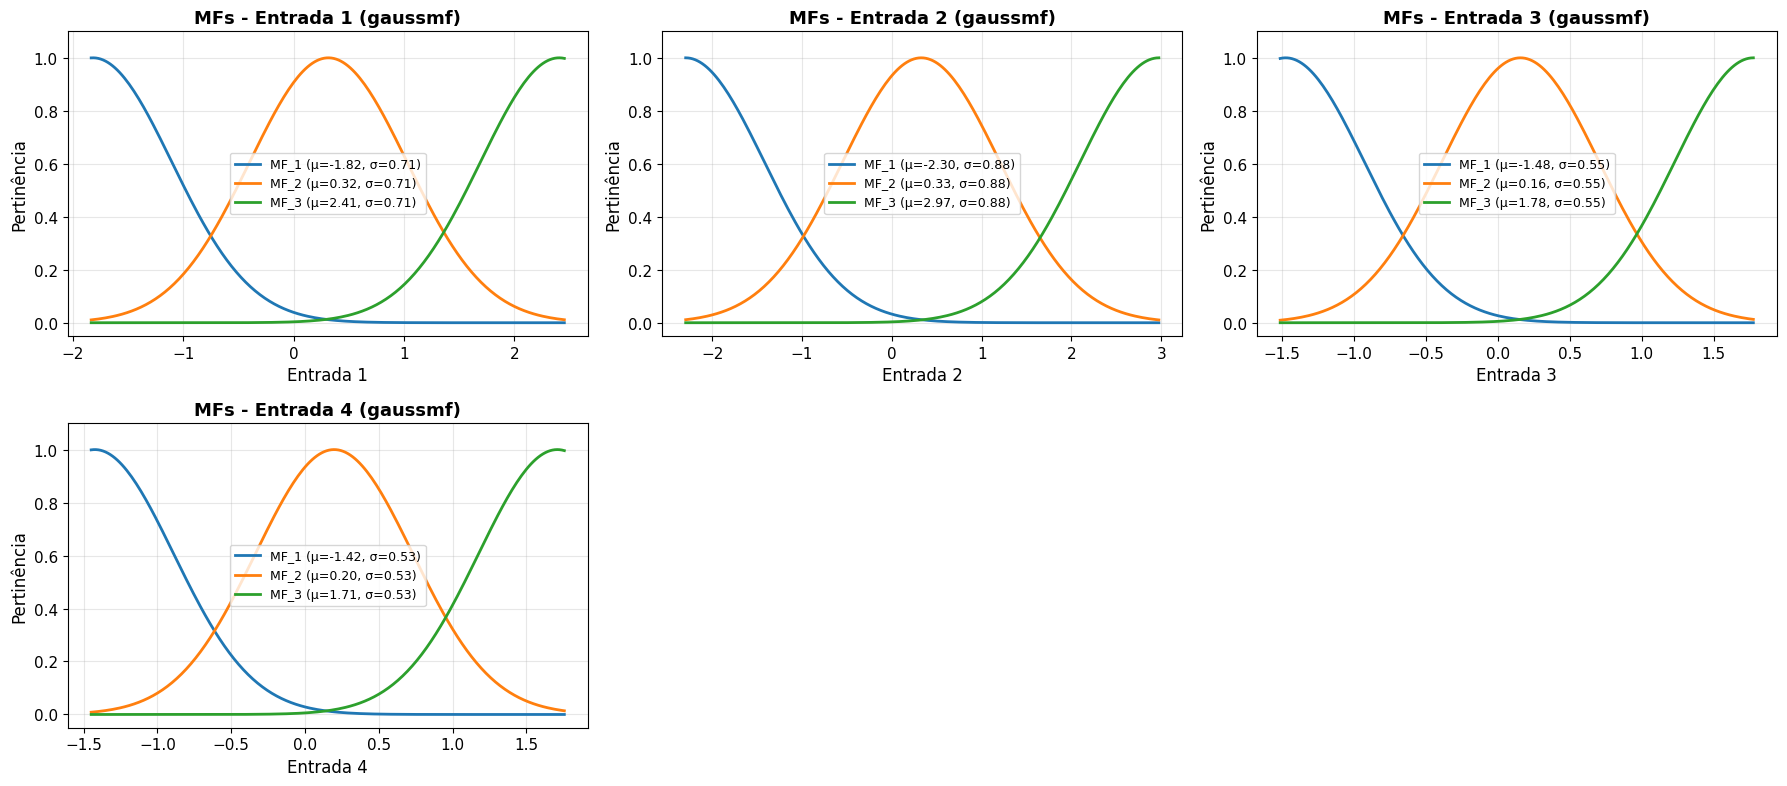

In [ ]:
model_cls.plotar_

In [12]:
confusion_matrix(y_pred_cls,y_test)

array([[ 8,  0],
       [ 0, 15]])

In [ ]:
# Scatter plot colorido por classe
plt.figure(figsize=(10, 7))

colors = ['red', 'green', 'blue']
markers = ['o', 's', '^']

for i, (name, color, marker) in enumerate(zip(class_names, colors, markers)):
    idx = y == i
    plt.scatter(X[idx, 2], X[idx, 3], 
                c=color, marker=marker, s=100, 
                label=name, alpha=0.7, edgecolors='black')

plt.xlabel('Petal Length (cm)', fontsize=12)
plt.ylabel('Petal Width (cm)', fontsize=12)
plt.title('Dataset Iris - Visualização 2D', fontsize=14, fontweight='bold')
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print('✅ As classes são visualmente separáveis!')

In [ ]:
# ============================================================================
# 1. LOAD AND PREPARE DATA
# ============================================================================

print("="*70)
print("🌸 WANG-MENDEL CLASSIFICATION - IRIS DATASET")
print("="*70)


print(f"\n📊 Dataset Information:")
print(f"   • Samples: {X.shape[0]}")
print(f"   • Features: {X.shape[1]} ({', '.join(feature_names)})")
print(f"   • Classes: {len(class_names)} ({', '.join(class_names)})")

# One-hot encode labels
encoder = OneHotEncoder(sparse_output=False)
y_onehot = encoder.fit_transform(y.reshape(-1, 1))

print(f"\n   • Target shape: {y.shape} → One-hot: {y_onehot.shape}")

# Train-test split
X_train, X_test, y_train_onehot, y_test_onehot = train_test_split(
    X, y_onehot, test_size=0.3, random_state=42, stratify=y
)
y_train = np.argmax(y_train_onehot, axis=1)
y_test = np.argmax(y_test_onehot, axis=1)

print(f"\n   • Train samples: {X_train.shape[0]}")
print(f"   • Test samples: {X_test.shape[0]}")


In [ ]:
# Obter memberships
memberships = wm.predict_membership(X_test)

# Para classificação Iris (3 classes × 2 termos cada = 'no'/'yes')
print(memberships['setosa'].shape)  # (45, 2) - 45 amostras, 2 termos

# Primeira amostra
print(f"Setosa - no: {memberships['setosa'][0, 0]:.3f}, yes: {memberships['setosa'][0, 1]:.3f}")
print(f"Versicolor - no: {memberships['versicolor'][0, 0]:.3f}, yes: {memberships['versicolor'][0, 1]:.3f}")
print(f"Virginica - no: {memberships['virginica'][0, 0]:.3f}, yes: {memberships['virginica'][0, 1]:.3f}")

In [ ]:
# Obter informações detalhadas das primeiras 3 amostras
details = wm.predict_membership_detailed(X_test[:3])

for sample in details:
    print(f"\n=== Amostra {sample['sample_id']} ===")
    print(f"Saídas fuzzy brutas: {sample['raw_outputs']}")
    
    print("\nGraus de pertinência:")
    for var_name, term_memberships in sample['memberships'].items():
        print(f"  {var_name}:")
        for term, degree in term_memberships.items():
            print(f"    {term}: {degree:.4f}")
    
    print("\nTermos dominantes:")
    for var_name, (term, degree) in sample['dominant_terms'].items():
        print(f"  {var_name}: '{term}' ({degree:.4f})")


In [ ]:
import matplotlib.pyplot as plt

# Obter memberships
memberships = wm.predict_membership(X_test)

# Plot para primeira amostra
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

for idx, (var_name, ax) in enumerate(zip(['setosa', 'versicolor', 'virginica'], axes)):
    mem = memberships[var_name][0]  # Primeira amostra
    terms = ['no', 'yes']
    
    ax.bar(terms, mem, color=['red', 'green'], alpha=0.7, edgecolor='black')
    ax.set_ylim(0, 1)
    ax.set_ylabel('Membership Degree', fontweight='bold')
    ax.set_title(f'{var_name.capitalize()}', fontsize=13, fontweight='bold')
    ax.grid(True, alpha=0.3, axis='y')

plt.suptitle('Membership Degrees - Sample 1', fontsize=15, fontweight='bold')
plt.tight_layout()
plt.show()


In [ ]:
# Amostras onde nenhum termo tem membership > 0.6
memberships = wm.predict_membership(X_test)

uncertain_samples = []
for i in range(len(X_test)):
    max_memberships = []
    for var_name in ['setosa', 'versicolor', 'virginica']:
        max_mem = memberships[var_name][i].max()
        max_memberships.append(max_mem)
    
    if max(max_memberships) < 0.65:
        uncertain_samples.append(i)

print(f"Amostras incertas: {uncertain_samples}")
